In [1]:
from PIL import Image
import numpy as np
from IPython.display import display
import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

width = 48
height = 48
in_c = 3
lamda = 10

nz = 40

lrD = 1e-4
lrG = 1e-4
batchsize = 64
imagesize = 48
fc = 128 # D or G network first out channels

/home/ubuntu/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import glob
png_list = glob.glob('../anime/animeface-character-dataset/thumb/*/*.png')

In [3]:
train_X = np.ones((len(png_list), height, width, in_c))
for i, png in enumerate(png_list):
    img = Image.open(png)
    img.thumbnail((height, width))
    img = np.array(img)/255*2-1
    h, w, c = img.shape
    x = (width - w) // 2
    y = (height - h) // 2
    train_X[i, y:y+h, x:x+w, :] = img[:, :, 0:3]

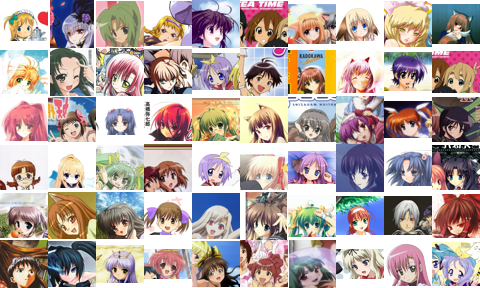

In [4]:
def showX(int_X, rows=1):
    int_X = ((int_X + 1) * 255 / 2).clip(0, 255).astype('uint8')
    int_X = int_X.reshape(rows, -1, height, width, 3)
    int_X = int_X.swapaxes(1, 2).reshape(rows*height, -1, 3)
    img = Image.fromarray(int_X)
    display(img)
    
train_X = np.concatenate((train_X[:,:,::-1,:], train_X))
np.random.shuffle(train_X)
showX(train_X[0:60], 6)

In [5]:
def LeakyRelu(x, leak=0.2):
    return tf.maximum(x, x*leak)

convInit = tf.initializers.random_normal(0, 0.02)
gammaInit = tf.initializers.random_normal(1., 0.02)

In [6]:
def discriminator(x, imagesize, firstc, isTrain=True, reuse=False):
    nextsize, nextc = imagesize, firstc
    _ = x
    with tf.variable_scope('discriminator', reuse=reuse):
        while nextsize > 5:
            _ = tf.layers.conv2d(_, nextc, [4, 4], strides=(2, 2), padding='same', kernel_initializer=convInit,
                                 activation=LeakyRelu, use_bias=False)
            nextsize, nextc = nextsize//2, nextc*2
        out = tf.layers.conv2d(_, 1, [nextsize, nextsize], strides=(1, 1), padding='valid', kernel_initializer=convInit,
                              use_bias=False)
        #out = tf.layers.flatten(_)
        return out

In [7]:
def generator(x, imagesize, lastc, isTrain=True, reuse=False):
    nextsize, nextc = imagesize, lastc//2
    _ = tf.reshape(x, shape=(-1, 1, 1, nz))
    while nextsize > 5:
        nextc = nextc * 2
        nextsize = nextsize // 2
    with tf.variable_scope('generator', reuse=reuse):
        _ = tf.layers.conv2d_transpose(_, nextc, [nextsize, nextsize], strides=(1, 1), padding='valid',
                                       use_bias=True, kernel_initializer=convInit)
        _ = tf.layers.batch_normalization(_, training=isTrain, epsilon=1.01e-5, gamma_initializer=gammaInit,
                                          momentum=0.9)
        _ = tf.nn.relu(_)
        while nextsize < imagesize//2:
            nextc = nextc // 2
            _ = tf.layers.conv2d_transpose(_, nextc, [4, 4], strides=(2, 2), padding='same',
                                           use_bias=True, kernel_initializer=convInit)
            _ = tf.layers.batch_normalization(_, training=isTrain, epsilon=1e-5, gamma_initializer=gammaInit,
                                              momentum=0.9)
            _ = tf.nn.relu(_)
            nextsize = nextsize * 2
            nextc = nextc // 2
        _ = tf.layers.conv2d_transpose(_, in_c, [4, 4], strides=(2, 2), padding='same',
                                       use_bias=True, kernel_initializer=convInit)
        out = tf.nn.tanh(_)
        return out

In [9]:
X = tf.placeholder(dtype=tf.float32, shape=[None, height, width, 3])
Z = tf.placeholder(dtype=tf.float32, shape=[None, nz])
isTrain = tf.placeholder(dtype=tf.bool)
epsilon_input = tf.placeholder(dtype=tf.float32, shape=[None, 1, 1, 1])

G_sample = generator(Z, imagesize, fc, isTrain)

D_mixed_input = epsilon_input * G_sample + (1 - epsilon_input) * X
grad_mixed = tf.gradients(discriminator(D_mixed_input, imagesize, fc), D_mixed_input)[0]
norm_grad_mixed = tf.sqrt(tf.reduce_sum(tf.square(grad_mixed), axis=[1,2,3]))
grad_penalty = tf.reduce_mean(tf.square(norm_grad_mixed - 1))

D_real = discriminator(X, imagesize, fc, isTrain, True)
D_fake = discriminator(G_sample, imagesize, fc, isTrain, True)
D_loss_real = tf.reduce_mean(D_real)
D_loss_fake = tf.reduce_mean(D_fake)

D_loss = D_loss_fake - D_loss_real + lamda * grad_penalty
G_loss = -D_loss_fake

T_vars = tf.trainable_variables()
D_vars = [var for var in T_vars if var.name.startswith('discriminator')]
G_vars = [var for var in T_vars if var.name.startswith('generator')]
D_optimizer = tf.train.AdamOptimizer(lrD, beta1=0.0, beta2=0.9).minimize(D_loss, var_list=D_vars)
G_optimizer = tf.train.AdamOptimizer(lrG, beta1=0.0, beta2=0.9).minimize(G_loss, var_list=G_vars)

sess.run(tf.global_variables_initializer())

[0/0], D_loss_curr -106.92695617675781, G_loss_curr 0


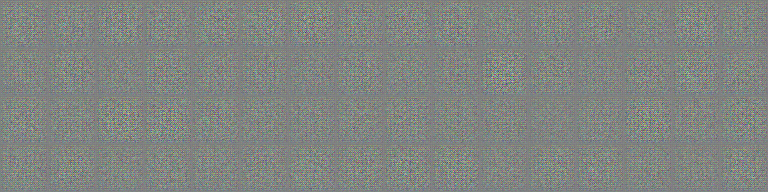

[10/500], D_loss_curr -14.489862442016602, G_loss_curr -23.394081115722656


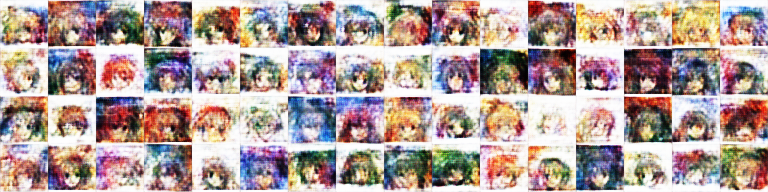

[15/1000], D_loss_curr -11.376055717468262, G_loss_curr -9.498339653015137


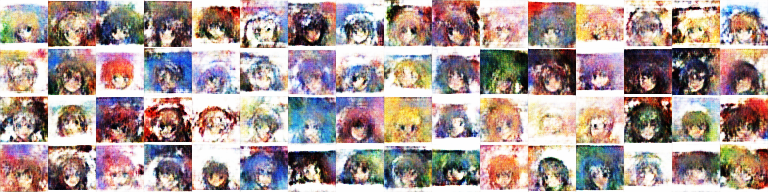

[21/1500], D_loss_curr -10.804765701293945, G_loss_curr -6.627042770385742


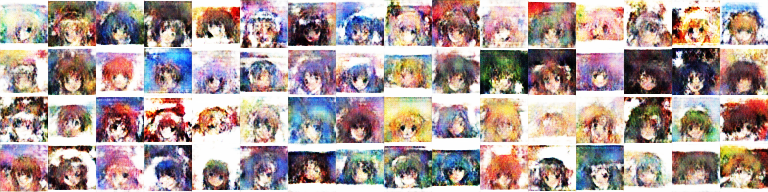

In [ ]:
epoch_num = 200
gen_iter = 0
G_loss_ = 0
fixed_noise = np.random.normal(size=(batchsize, nz)).astype('float32')
for epoch in range(epoch_num):
    i = 0;
    np.random.shuffle(train_X)
    batches = train_X.shape[0] // batchsize
    while i < batches:
        if gen_iter < 25 or gen_iter % 500 == 0:
            _Diters = 100
        else:
            _Diters = 5
        j = 0
        while j < _Diters and i < batches:
            real_data = train_X[i*batchsize:(i+1)*batchsize]
            i += 1
            j += 1
            noise = np.random.normal(size=(batchsize, nz)).astype('float32')
            random_epsilon = np.random.uniform(size=(batchsize, 1, 1, 1)).astype('float32')
            D_loss_, _ = sess.run([D_loss, D_optimizer], feed_dict={X: real_data, Z: noise, isTrain: True, epsilon_input:random_epsilon})
        
        if gen_iter % 500 == 0:
            print('[{}/{}], D_loss_curr {}, G_loss_curr {}'.format(epoch, gen_iter, D_loss_, G_loss_))
            G_Z = sess.run(G_sample, feed_dict={Z: fixed_noise, isTrain: True})
            showX(G_Z, 4)

        noise = np.random.normal(size=(batchsize, nz)).astype('float32')
        G_loss_, _ = sess.run([G_loss, G_optimizer], feed_dict={Z: noise, isTrain: True})
        gen_iter = gen_iter + 1